In [1]:
import glob
import skimage.io as io
import numpy as np
#import commonfunctions as cf
import sklearn
from skimage.feature import hog
from sklearn.model_selection import train_test_split, cross_val_score, cross_val_predict, RandomizedSearchCV
from sklearn import svm
import matplotlib.pyplot as plt
from skimage.transform import rescale, resize, downscale_local_mean
from sklearn import metrics
from sklearn.preprocessing import MinMaxScaler

import pickle
import cv2
import random
import os

from PIL import Image, ImageEnhance

import argparse
from datetime import datetime
# from sklearn.metrics import classification_report, confusion_matrix
# from sklearn.svm import SVC
# from sklearn.metrics import *



In [2]:
'''
if you want to load the data again to work with them
'''

male_data=np.load('male_data.npy',allow_pickle=True)
# female_data=np.load('female_data.npy',allow_pickle=True)

EOFError: Ran out of input

(2712, 1940)


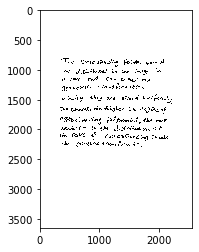

In [ ]:
print(male_data[0].shape)
plt.imshow(male_data[0],cmap='gray')

In [ ]:

# for i,img in enumerate(male_data):
#     k=5
#     wshape=(100*k,142*k)

#     male_data[i]=cv2.resize(img,wshape)

In [ ]:
# for i,img in enumerate(female_data):
#     k=5
#     wshape=(100*k,142*k)

#     female_data[i]=cv2.resize(img,wshape)

True

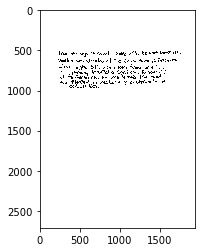

In [ ]:
plt.imshow(male_data[0],cmap='gray')
cv2.imwrite("lol.jpg",male_data[0])

In [ ]:
N_ANGLE_BINS = 40
BIN_SIZE = 360 // N_ANGLE_BINS
LEG_LENGTH = 25

def get_contour_pixels(bw_image):
    contours, _= cv2.findContours(
        bw_image, cv2.RETR_TREE, 
        cv2.CHAIN_APPROX_NONE
        ) 
    # contours = imutils.grab_contours(contours)
    contours = sorted(contours, key=cv2.contourArea, reverse=True)[1:]
    
    img2 = bw_image.copy()[:,:,np.newaxis]
    img2 = np.concatenate([img2, img2, img2], axis = 2)
    
    # if self.show_images:
    #     for cnt in contours : 
    #         cv2.drawContours(img2, [cnt], 0, (255, 0, 0), 1)  
            
    #     plt.imshow(img2, cmap='gray')
    return contours

def get_hinge_features(bw_image):
    # if self.is_binary:
    #     bw_image, _ = self.preprocess_binary_image(img_file, self.sharpness_factor, self.bordersize)
    # else:
    #     bw_image, _ = self.preprocess_image(img_file, self.sharpness_factor, self.bordersize)
    
    contours = get_contour_pixels(bw_image)
    
    hist = np.zeros((N_ANGLE_BINS, N_ANGLE_BINS))
        
    # print([len(cnt) for cnt in contours])
    for cnt in contours:
        n_pixels = len(cnt)
        if n_pixels <= LEG_LENGTH:
            continue
        
        points = np.array([point[0] for point in cnt])
        xs, ys = points[:, 0], points[:, 1]
        point_1s = np.array([cnt[(i + LEG_LENGTH) % n_pixels][0] for i in range(n_pixels)])
        point_2s = np.array([cnt[(i - LEG_LENGTH) % n_pixels][0] for i in range(n_pixels)])
        x1s, y1s = point_1s[:, 0], point_1s[:, 1]
        x2s, y2s = point_2s[:, 0], point_2s[:, 1]
        
        phi_1s = np.degrees(np.arctan2(y1s - ys, x1s - xs) + np.pi)
        phi_2s = np.degrees(np.arctan2(y2s - ys, x2s - xs) + np.pi)
        
        indices = np.where(phi_2s > phi_1s)[0]
        
        for i in indices:
            phi1 = int(phi_1s[i] // BIN_SIZE) % N_ANGLE_BINS
            phi2 = int(phi_2s[i] // BIN_SIZE) % N_ANGLE_BINS
            hist[phi1, phi2] += 1
            
    normalised_hist = hist / np.sum(hist)
    feature_vector = normalised_hist[np.triu_indices_from(normalised_hist, k = 1)]
    
    return feature_vector

    

In [ ]:


hinge_male=[]
hinge_female=[]

for i,img in enumerate(male_data):
    try:
        hinge_male.append(get_hinge_features(img))
    except :
        print(i)

# for i,img in enumerate(female_data):
#     try:
#         hinge_female.append(get_hinge_features(img))
#     except:
#         print(i)

hinge_male=np.array(hinge_male)
# hinge_female=np.array(hinge_female)

125
126
127
128
129
130
131
132


In [ ]:
X=np.concatenate((hinge_male,hinge_female),axis=0)

Y=np.concatenate((np.ones(hinge_male.shape[0]),
                np.zeros(hinge_female.shape[0])),
                axis=0)

In [ ]:
print(X.shape, Y.shape)

(250, 780) (250,)


In [ ]:
X,Y=sklearn.utils.shuffle(X,Y)

In [ ]:
# X_train=X[:200]
# Y_train=Y[:200]

# X_test=X[200:]
# Y_test=Y[200:]

X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2,random_state=109) # 70% training and 30% test


In [ ]:
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

(200, 780) (50, 780) (200,) (50,)


In [ ]:
clf = svm.SVC(kernel='rbf', verbose=True, C=10)

clf.fit(X_train, y_train)


[LibSVM]..*.*
optimization finished, #iter = 642


SVC(C=10, verbose=True)

obj = -273.733871, rho = 0.797691
nSV = 171, nBSV = 3
Total nSV = 171


In [ ]:

y_pred = clf.predict(X_test)

In [ ]:

# Model Accuracy: how often is the classifier correct?
print("Accuracy:",metrics.accuracy_score(y_test, y_pred))

Accuracy: 0.9


In [ ]:

# Model Precision: what percentage of positive tuples are labeled as such?
print("Precision:",metrics.precision_score(y_test, y_pred))

# Model Recall: what percentage of positive tuples are labelled as such?
print("Recall:",metrics.recall_score(y_test, y_pred))

Precision: 0.8461538461538461
Recall: 0.9565217391304348
